In [3]:
library(dplyr)
library(survival)
library(reshape2)
library(tibble)
library(xtable)

## Plotting
library(ggplot2)
library(cowplot)
library(pROC)

library(RColorBrewer)
library(pheatmap)
# library(rgl)
# library(VennDiagram)
# library(UpSetR)
# library(Rtsne)
# library(dendextend)
# library(repr)
# options(repr.plot.width=8, repr.plot.height=4)

theme_set(theme_bw())


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************

Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var



In [4]:
source("R/calc.R")
source("R/misc.R")
source("R/normalise.R")
source("R/plot.R")
source("R/predict.R")
source("R/subset.R")
source("R/utils.R")

## Import data

In [5]:
## Metadata
METADATA_RPATH <- "data/GSE67684/processed/metadata/sid-metadata_v2.tsv"
LABEL_RPATH <- "data/GSE67684/processed/metadata/pid-metadata_v4.tsv"
BATCH_RPATH <- "data/GSE67684/processed/metadata/sid-batch.tsv"

metadata_df <- read.table(METADATA_RPATH, sep = "\t")
yeoh_batch <- read.table(BATCH_RPATH, sep = "\t", header = T, row.names = 1)
yeoh_label <- read.table(LABEL_RPATH, sep = "\t", header = T, row.names = 1)
yeoh_label[] <- lapply(yeoh_label, as.factor)

## Subset of original data
# Removed outliers, patients with timepoints from different batches and batch 5
SUBSET_RPATH <- "data/GSE67684/processed/subset_yeoh.tsv"
raw_yeoh <- read.table(SUBSET_RPATH, sep = "\t")
# SCALE->REMOVE->FILTER->LOG
scaled_yeoh <- normaliseMeanScaling(raw_yeoh)
selected_yeoh <- removeProbesets(scaled_yeoh)
data <- log2_transform(filterProbesets(selected_yeoh, 0.7, metadata_df))

  P001_D0   P004_D0   P005_D0   P007_D0   P008_D0   P009_D0 
 5.796952  4.123342  3.981577  6.317643  4.841458 11.978124 
[1] "No. of ambiguous and AFFY probesets removed: 10503"
[1] D0 D0 D0 D0 D0 D0
Levels: D0 D8 N
           D0    D8     N
1053_at  TRUE  TRUE  TRUE
117_at  FALSE  TRUE  TRUE
121_at   TRUE  TRUE  TRUE
1294_at  TRUE  TRUE  TRUE
1316_at  TRUE  TRUE  TRUE
1320_at FALSE FALSE FALSE
[1] "No. of probesets removed = 6321"


In [6]:
yeoh_allps <- log2_transform(scaled_yeoh)
yeoh_unfltr <- log2_transform(selected_yeoh)

#### Day 33

In [7]:
path1 <- "data/leuk_D33/processed/mas5_filtered.tsv"
path2 <- "data/GSE67684/processed/metadata/sid-metadata_v1.tsv"

yeoh_d33 <- read.table(path1, sep = "\t", header = T)
annot_all <- read.table(path2, sep = "\t", header = T)

annot_all[] <- lapply(annot_all, as.factor)
annot_all$class_info<- factor(
  annot_all$class_info,
  levels = c('D0', 'D8', 'D33', 'N')
)

yeoh_d33_allps <- log2_transform(normaliseMeanScaling(yeoh_d33))
# Remove samples that have been curated out of data set
# Members that have been curated out are no longer in annot_all
missing_samples <- colnames(yeoh_d33_allps)[
  !(colnames(yeoh_d33_allps) %in% rownames(annot_all))]
# Remove patients from D33 that have been curated out
yeoh_d33 <- yeoh_d33_allps[
  rownames(data),
  !(colnames(yeoh_d33_allps) %in% missing_samples)
]

P001_D33 P006_D33 P007_D33 P008_D33 P009_D33 P010_D33 
2.106859 2.132480 1.498776 2.559182 1.576584 2.657973 


In [9]:
# allyeoh <- allyeoh_allps[rownames(data), ]

### Commonly used globals

In [10]:
COL_LABEL <- c("darkolivegreen3", "tomato3")

annot <- metadata_df[colnames(data),]
Y_annot <- annot[,c("batch_info", "label")] # heatmap annot
# Y_all <- all_metadata[colnames(data_all),]

# List subtypes
subtypes9 <- levels(metadata_df$subtype)
subtypes7 <- setdiff(subtypes9, c("Hypodiploid", "Normal"))
subtypes6 <- setdiff(subtypes7, "Others")
subtypes5 <- setdiff(
  subtypes9,
  c("Hypodiploid", "Normal", "Hyperdiploid", "Others")
)
others <- data[, annot$subtype == "Others"]
others_normal <- data[, annot$subtype %in% c("Others", "Normal")]

heatmap_annot <- annot[, c("batch_info", "label"), drop = F]

In [11]:
# Define train/test split
sid_mrd_na <- rownames(yeoh_label)[is.na(yeoh_label$d33_mrd)] %>%
  rep(each = 2) %>%
  paste0(c("_D0", "_D8"))

sid_alltrain_local <- rownames(annot)[
  !(annot$subtype %in% c("Hypodiploid", "Normal")) &
  !(rownames(annot) %in% sid_mrd_na)
]
sid_alltrain <- rownames(annot)[
  !(annot$subtype %in% c("Hypodiploid", "Hyperdiploid", "Others", "Normal")) &
  !(rownames(annot) %in% sid_mrd_na)
]
sid_train <- rownames(annot)[
  annot$batch_info %in% 1:7 &
  !(annot$subtype %in% c("Hypodiploid", "Hyperdiploid", "Others", "Normal")) &
  !(rownames(annot) %in% sid_mrd_na)
]
sid_test <- rownames(annot)[
  annot$batch_info %in% 8:10 &
  !(annot$subtype %in% c("Hypodiploid", "Hyperdiploid", "Others", "Normal")) &
  !(rownames(annot) %in% sid_mrd_na)
]

sid_remission <- rownames(annot)[annot$label == 0]
sid_normal <- paste0("N0", c(1,2,4))

#### Remove batch effect genes

In [12]:
batch_ps <- identify_batch_features(data, annot, method = 'aov')
length(batch_ps)

[1] "No. of NaNs = 0"


[1] 2565

### Plot: Vectors (UMAP)

In [134]:
# #' Performs PCA and plots vectors. Assume: 3 normal samples
# #' @param X dataframe with features x samples and containing
# #' D0, D8 and 3 Normal patients (ordered correctly)
# plot_vectors <- function(
#   X, metadata_df, pca = T, cex = 3, main = NULL
# ) {
#   # PCA
#   if (pca) {
#     pca_obj <- prcomp(t(X), scale = T)
#     pca_df <- data.frame(pca_obj$x[,1:2])
#     n <- nrow(pca_df)
#     d0_pca <- pca_df[1:((n-3) / 2),]
#     d8_pca <- pca_df[((n-1) / 2):(n-3),]
    
#     stopifnot(all(substring(rownames(d0_pca), 1, 4) == substring(rownames(d8_pca), 1, 4)))
    
#     subtype_pca <- cbind(d0_pca, d8_pca)
#     colnames(subtype_pca) <- c("start_x", "start_y", "end_x", "end_y")
#     norm_pca <- pca_df[(n-2):n,]
    
#     # Obtaining batch and class annotations
#     label <- as.numeric(metadata_df[rownames(d0_pca), "label"]) + 1
#     batch <- as.factor(metadata_df[rownames(d0_pca), "batch_info"])
#     print(label)
    
#     # Axis labels
#     eigenvalues <- (pca_obj$sdev)^2
#     var_pc <- eigenvalues[1:4]/sum(eigenvalues)
#     pc_labels <- sprintf("PC%d (%.2f%%)", 1:4, var_pc*100)
#   } else {
#     print("No PCA performed!")
#     pca_df <- data.frame(X)
#   }
  
#   scatter_pca <- ggplot(data = subtype_pca) +
#     geom_point(aes(x = start_x, y = start_y, colour = batch), shape = 15,
#                size = cex, show.legend = T) +
#     geom_point(aes(x = end_x, y = end_y, colour = batch), shape = 16,
#                size = cex, show.legend = F) +
#     geom_segment(aes(x = start_x, y = start_y, xend = end_x, yend = end_y),
#                  arrow = arrow(length = unit(0.3, "cm")),
#                  alpha = 0.5, colour = label) +
# #     geom_text(aes(x = PC1_A, y = PC2_A,
# #                   label = rownames(subtype_pca)),
# #               position = position_nudge(x = 4, y = 2), size = 2.5) +
#     geom_point(data = norm_pca, aes(x = PC1, y = PC2),
#                size = cex, shape = 17)
  
#   if (pca) {
#     scatter_pca <- scatter_pca +
#       xlab(pc_labels[1]) + ylab(pc_labels[2])
#   }
  
#   if (!is.null(main)) {
#     scatter_pca <- scatter_pca + labs(title = main)
#   }
  
#   return(scatter_pca)
# }

In [152]:
# umap_others <- umap(t(others_normal))

In [129]:
# umap_others1 <- cbind(
#   x = umap_others$layout,
#   Y[rownames(umap_others$layout), ]
# )

# umap_others2 <- umap_others1[umap_others1$subtype == "Others", ]
# umap_normal <- umap_others1[umap_others1$subtype == "Normal", ]
# umap_others3 <- umap_others2[seq_len(nrow(umap_others2) / 2), ]
# others_d8 <- umap_others2[seq(nrow(umap_others2) / 2 + 1, nrow(umap_others2)), 1:2]
# umap_others4 <- cbind(umap_others3, others_d8)
# umap_others4 <- umap_others4[, c(1,2,7,8,3:6)]
# colnames(umap_others4)[1:4] <- c("start_x", "start_y", "end_x", "end_y")
# umap_others4$batch_info <- as.factor(umap_others4$batch_info)
# umap_others4$label <- as.factor(umap_others4$label)
# arrow_col <- ifelse(umap_others4$label == 0, "black", "red")

# scatter_pca <- ggplot(data = umap_others4) +
#   geom_point(aes(x = start_x, y = start_y, colour = batch_info),
#              shape = 15, size = cex, show.legend = T) +
#   geom_point(aes(x = end_x, y = end_y, colour = batch_info),
#              shape = 16, size = cex, show.legend = F) +
#   geom_segment(
#     aes(x = start_x, y = start_y, xend = end_x, yend = end_y),
#     arrow = arrow(length = unit(0.3, "cm")),
#     alpha = 0.5,
#     color = arrow_col
#   ) +
#   geom_point(data = umap_normal, aes(x = x.1, y = x.2),
#              size = cex, shape = 17)

# ggsave("~/Dropbox/temp/umap-others.pdf", scatter_pca)

Saving 6.67 x 6.67 in image


## Plot: Vectors (PCA)

In [139]:
# pca_all <- plot_vectors(others, Y)
# ggsave("~/Dropbox/temp/vectors-pca_all.pdf", pca_all)

# others_fltr <- others[!(rownames(others) %in% batch_genes), ]
# pca_wo_batch <- plot_vectors(others_fltr, Y)
# ggsave("~/Dropbox/temp/vectors-pca_wo_batch.pdf")

 [1] 1 1 1 2 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 2 2 2 2 1 2 2
[39] 1 2 1 1 1 1 2 2 1 1 1 2 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 2 1 2 1 1 1 2 1 1
[77] 1 1 2 1 1 1 1 2 1


Saving 6.67 x 6.67 in image


# Important genes

## Plot: Heatmap

In [13]:
#' Annotates affymetrix probesets to gene ID of choice
#'
#' Annotates affymetrix probesets according to platform and gene
#' naming convention provided in the annotation file. Option of
#' returning vector of annotaions with probesets as names
#'
#' Removes probesets with no matching ID. If multiple probesets
#' map to a single ID, the probeset with the max sum is used.
#' @param X data.frame with affy probesets as rownames
#' @param file name of the annotation file
#' @param ret.annot logical indicating whether to return vector of annotations
affy2id <- function(X, file, ret.annot = F) { 
  # probesets are rownames of dataframe
  annot_table <- read.table(
    file, sep = "\t", header = T, row.names = 1,
    stringsAsFactors = F, strip.white = T
  )
#   # Filters out ambiguous and AFFY probesets from annot 
#   fltr_annot <- annot_table[
#     grepl("[0-9]_at", rownames(annot_table)) 
#     & !startsWith(rownames(annot_table), "A"),
#     , drop = F
#   ]
  orig_rownames <- annot_table[rownames(X), ]
                      
  msg_no_id <- sprintf( 
    "No. of probesets with no ID removed: %d\n", sum(orig_rownames == "")
  )
  cat(msg_no_id)
   
  # Indices of probe sets with no corresponding ID to be deleted 
  idx_del <- which(orig_rownames == "")
   
  # Identifies genes that have multiple probesets mapping to it 
  freq_gene <- table(orig_rownames)
  dup_genes <- names(freq_gene[freq_gene > 1])
  dup_genes <- setdiff(dup_genes, "")
  for (gene in dup_genes) {
    # subset rows of dataframe with the same id
    same_rows <- X[orig_rownames == gene, , drop = F] 
    # assign numeric indices as rownames 
    rownames(same_rows) <- which(orig_rownames == gene)
    # rows that do not have the maximum sum are deleted 
    row_del <- as.numeric(
      rownames(same_rows)[-which.max(rowSums(same_rows))]
    )
    # concat with existing list of indices to be deleted 
    idx_del <- c(idx_del, row_del)
  }
  
  msg_total <- sprintf(
    "Total no. of probesets removed (incl. probesets mapping to same gene): %d\n", 
    length(idx_del)
  ) 
  cat(msg_total)
  
  # Rows are deleted 
  X_genes <- X[-idx_del, ]
  fltr_rownames <- orig_rownames[-idx_del]
  names(fltr_rownames) <- rownames(X)[-idx_del]
  # Assigning id to X
  rownames(X_genes) <- fltr_rownames
  
  if (ret.annot) {
    orig_rownames[idx_del] <- NA
    names(orig_rownames) <- rownames(X)
    return(orig_rownames)
  }
  
  X_genes
}

In [950]:
# # Hierarchical clustering
# heatmap_annot <- Y[, c("class_info", "label", "subtype"), drop = F]
# # heatmap_annot$batch_info <- as.double(heatmap_annot$batch_info)

# pheatmap(
#   yeoh_cd, col = brewer.pal(n = 11, name = "RdBu"), # col = brewer.pal(9, "Blues"),
#   display_numbers = F, legend = T, border_color = NA,
#   scale = "row",
#   cluster_method = "ward.D2", cluster_rows = T, cluster_cols = T,
# #   cutree_cols = 4,
#   annotation_col = heatmap_annot,
#   show_colnames = T, show_rownames = T,
#   fontsize = 3, cellwidth = 4, cellheight = 4,
#   filename = "~/Dropbox/temp/heatmap-cd.pdf"
# )

#### HVGs

In [1080]:
# Filtering out low variance genes
hvg_cd <- select_hvg(yeoh_cd, 30)
pheatmap(
  hvg_cd, col = brewer.pal(n = 11, name = "RdBu"), # col = brewer.pal(9, "Blues"),
  display_numbers = F, legend = T, border_color = NA,
  scale = "row",
  cluster_method = "ward.D2", cluster_rows = T, cluster_cols = T,
#   cutree_cols = 4,
  annotation_col = heatmap_annot,
  show_colnames = F, show_rownames = T,
  fontsize = 12, cellwidth = 4, cellheight = 16,
  filename = "~/Dropbox/temp/heatmap-hvg_cd.pdf"
)

#### Literature genes

In [1118]:
# # Yeoh et al. (2002)
# cd1 <- c('CD2', 'CD3', 'CD8', 'CD10', 'CD19', 'CD22')
# # Good et al. (2018)
# cd2 <- c('CD24', 'CD34', 'CD38', 'CD19', 'CD179', 'CD127')
# cd3 <- c(
#   'CD10', 'CD123', 'CD127', 'CD179', 'CD19', 'CD20', 'CD22',
#   'CD24', 'CD34', 'CD38', 'CD43', 'CD45', 'CD58', 'CD79b'
# )

# ## Important CD proteins obtained from Yeoh et al. (2002) and Good et al. (2018)
# # lapply(cd3, function(gene) grep(gene, genes1, value = T))
# impt_cd <- c(
#   'CD2', 'CD3D', 'CD3E', 'CD3G', 'CD8A', 'CD8B',
#   'CD19', 'CD22', 'CD24', 'CD34', 'CD38', 'CD58'
# )

In [1137]:
# # Literature genes
# idx_ball <- annot[colnames(yeoh_cd), 'subtype'] != 'T-ALL'
# lit_cd_sub <- lit_cd[impt_cd, idx_ball]

# heatmap_annot <- annot[, c('subtype', 'class_info', 'label')]
# pheatmap(
#   lit_cd_sub, col = brewer.pal(n = 11, name = "RdBu"), # col = brewer.pal(9, "Blues"),
#   display_numbers = F, legend = T, border_color = NA,
#   scale = "row",
#   cluster_method = "ward.D2", cluster_rows = T, cluster_cols = T,
# #   cutree_cols = 4,
#   annotation_col = heatmap_annot,
#   show_colnames = F, show_rownames = T,
#   fontsize = 12, cellwidth = 2, cellheight = 30,
#   filename = "~/Dropbox/temp/heatmap_ball-literature_cd.pdf"
# )

# B-cell CD Markers

In [13]:
NAME_GPL570 <- "../info/microarray/HG-U133_Plus_2/annot_genesymbol-GPL570.tsv"
ann_allps <- affy2id(yeoh_allps, NAME_GPL570)
# ann_allyeoh_allps <- affy2id(allyeoh_allps, NAME_GPL570)

No. of probesets with no ID removed = 1052
Total no. of probesets removed (incl. probesets mapping to same gene): 8762


In [15]:
# Finalised list of B-cell CD markers (strictly B-cell)
strict_bcell <- c('CD19', 'CD38', 'CD72', 'CD79A', 'CD79B')

#### CD markers present in microarray data

In [15]:
# grep_genes <- grep('^CD[0-9]', rownames(a_allps), value = T)
# wrong_genes <- c('CD2BP2', 'CD2AP', 'CD3EAP', 'CD5L', 'CD40LG')
# cd_genes <- setdiff(grep_genes, wrong_genes)

# yeoh_cd <- a_allps[cd_genes, ]
# allyeoh_cd <- a_allyeoh_allps[cd_genes, ] # Includes D33 samples

In [1528]:
# # Grabbed from abcam website and Good et al. (2018)
# bcell_markers <- c(
#   'CD19', 'CD20', 'CD21', 'CD22', 'CD23', 'CD34', 'CD38',
#   'CD45R', 'CD72', 'CD74', 'CD79A', 'CD79B', 'CD81', 'CD85',
#   'CD139', 'CD361'
# )
# bmarkers_fltr <- bcell_markers[bcell_markers %in% rownames(yeoh_cd)]

In [1530]:
# # Non-specific B-cell CD markers
# nonspecific_bmarkers <- c(
#   'CD1C', 'CD1D', 'CD2', 'CD5', 'CD6', 'CD11B', 'CD11C', 'CD17',
#   'CD19', 'CD20', 'CD21', 'CD22', 'CD23', 'CD24', 'CD25', 'CD26',
#   'CD27', 'CD28', 'CD29', 'CD30', 'CD32', 'CD25', 'CD37', 'CD38',
#   'CD39', 'CD40', 'CD45RB', 'CD45RC', 'CD49B', 'CD49E', 'CD49F', 'CD72',
#   'CD74', 'CD77', 'CD79A', 'CD79B', 'CD84', 'CD85A', 'CD121A', 'CD122',
#   'CD127', 'CD130', 'CD134', 'CD135', 'CD150', 'CD152', 'CD162', 'CD166',
#   'CD171', 'CD179A', 'CD179B', 'CD180', 'CD184', 'CD185', 'CD186', 'CD197',
#   'CD200', 'CD203', 'CD213A2', 'CD224', 'CD225', 'CD229', 'CD232', 'CD252',
#   'CD258', 'CD267', 'CD268', 'CD269', 'CD274', 'CD279', 'CD290', 'C300A',
#   'CD300C', 'CD305', 'CD307A', 'CD307B', 'CD307C', 'CD307C', 'CD307D', 'CD307E',
#   'CD316', 'CD319', 'CD327', 'CD352', 'CD361'
# )

# nonspecific_fltr <- nonspecific_bmarkers[nonspecific_bmarkers %in% rownames(yeoh_cd)]

### Plot: Mean of B-cell markers

In [16]:
#' Warning: Handling of zeros and negative values
geometric_mean <- function(x, na.rm = T) {
  exp(sum(log(x[x > 0]), na.rm = na.rm) / length(x))
}

In [17]:
# Only B-cell markers and remove T-ALL samples
allyeoh_bcell <- ann_allyeoh_allps[
  strict_bcell,
  annot_all[colnames(ann_allyeoh_allps), 'subtype'] != 'T-ALL'
]

# Arithmetic mean
bcell_arith_mean <- colMeans(allyeoh_bcell)

# # Geometric mean
# bcell_geom_mean <- apply(bcell_sub1, 2, geometric_mean)

bcell_mean <- data.frame(
  bcell_mean = bcell_arith_mean,
  annot_all[names(bcell_arith_mean), ]
)

jitter_bcell <- ggplot(
  bcell_mean,
  aes(x = class_info, y = bcell_mean, fill = label)
) +
  geom_point(
    position = position_jitterdodge(),
    alpha = 1, pch = 21, cex = 2.5,
    show.legend = F
  ) +
  facet_wrap(~subtype, nrow = 2) +
  scale_fill_manual(values = COL_LABEL) +
  ylim(0, 14) +
  labs(
    x = 'Time point',
    y = expression(mu)
  )

# ggsave('~/Dropbox/temp/CD_mu.pdf',
#        jitter_bcell, width = 8, height = 5)

#### Plot: CD19

In [18]:
# Filter out hypodiploid and T-ALL subtypes
idx <- colnames(ann_allyeoh_allps)[
  annot_all[colnames(ann_allyeoh_allps), 'subtype'] != 'T-ALL']
cd19 <- ann_allyeoh_allps['CD19', idx, drop = F]
cd19_y <- data.frame(t(cd19), annot_all[idx, ])

jitter_cd19 <- ggplot(
  cd19_y,
  aes(x = class_info, y = CD19, fill = label)
) +
  geom_point(
    position = position_jitterdodge(),
    alpha = 1, pch = 21, cex = 2.5,
    show.legend = F
  ) +
  facet_wrap(~subtype, nrow = 2) +
  scale_fill_manual(values = COL_LABEL) +
  ylim(0, 14) +
  labs(
    x = 'Time point'
  )

# ggsave('~/Dropbox/temp/CD19.pdf',
#        jitter_cd19, width = 8, height = 5)

### Wilcoxon (paired): D0 v.s. D8

In [19]:
test_row <- function(x, f) {
  n <- length(x) / 2
  f(
    x[1:n], x[(n + 1):(n * 2)],
    alternative = 'greater',
    paired = TRUE,
    exact = TRUE
  )$p.value
}

calc_effect_size <- function(X, ret = c('mean_diff', 'cohen')) {
  stopifnot(is_paired(X))
  ret <- match.arg(ret)
  
  n <- ncol(X) / 2
  diff <- X[, 1:n] - X[, (n + 1):(n * 2)]
  mean_diff <- rowMeans(diff)
  sd_diff <- apply(diff, 1, sd)
  
  if (ret == 'cohen') {
    return(mean_diff / sd_diff)
  } else if (ret == 'mean_diff') {
    return(mean_diff)
  }
}

In [20]:
idx_ball <- colnames(ann_allps)[
  !(annot[colnames(ann_allps), 'subtype'] %in%
  c('T-ALL', 'Hypodiploid', 'Normal'))
]
cd19 <- ann_allps['CD19', idx_ball, drop = F]
ball <- rbind(cd19, mean =  bcell_arith_mean[idx_ball])

remission <- ball[, annot[colnames(ball), 'label'] == 0]
relapse <- ball[, annot[colnames(ball), 'label'] == 1]
subtypes_6 <- setdiff(subtypes7, 'T-ALL')

info_remission <- vector("list")
info_relapse <- vector("list")
for (subtype in subtypes_6) {
  # Remission
  subtype_remission <- remission[
    , annot[colnames(remission), 'subtype'] == subtype]
  
  stopifnot(is_paired(colnames(subtype_remission)))
  
  pvalues <- apply(subtype_remission, 1, test_row, t.test)
  eff_sz <- calc_effect_size(subtype_remission)
  n <- ncol(subtype_remission) / 2
  subtype_info <- c(pvalues, eff_sz, size = n)
  names(subtype_info)[1:4] <- paste(
    names(subtype_info)[1:4],
    rep(c('pvalue', 'eff'), each = 2),
    sep = '-'
  )
  info_remission <- append(info_remission, list(subtype_info))
  
  # Relapse
  subtype_relapse <- relapse[
    , annot[colnames(relapse), 'subtype'] == subtype]
  pvalues <- apply(subtype_relapse, 1, test_row, t.test)
  eff_sz <- calc_effect_size(subtype_relapse)
  n <- ncol(subtype_relapse) / 2
  subtype_info <- c(pvalues, eff_sz, size = n)
  names(subtype_info)[1:4] <- paste(
    names(subtype_info)[1:4],
    rep(c('pvalue', 'eff'), each = 2),
    sep = '-'
  )
  info_relapse <- append(info_relapse, list(subtype_info))
}

tab_remission <- sapply(info_remission, as.vector) %>%
  data.frame(row.names = names(subtype_info))
colnames(tab_remission) <- subtypes_6

tab_relapse <- sapply(info_relapse, as.vector) %>%
  data.frame(row.names = names(subtype_info))
colnames(tab_relapse) <- subtypes_6

### Plot: Paired t-test (CD19)

In [21]:
# Renamed label column to outcome!
annot_all1 <- annot_all
colnames(annot_all1)[4] <- 'outcome'
levels(annot_all1$outcome) <- c('Remission', 'Relapse')

In [22]:
remission_cd19 <- sprintf(
  'atop(paste(P == %.2g, "; ", n == %.0f), "Effect size = %.2f")',
  tab_remission[1, ],
  tab_remission[5, ],
  tab_remission[3, ]
)
relapse_cd19 <- sprintf(
  'atop(paste(P == %.2g, "; ", n == %.0f), "Effect size = %.2f")',
  tab_relapse[1, ],
  tab_relapse[5, ],
  tab_relapse[3, ]
)

# Annotation has to contain facet factors!
annot_remission <- data.frame(
  annot = remission_cd19,
  subtype = colnames(tab_remission),
  outcome = 'Remission',
  stringsAsFactors = F
)
annot_relapse <- data.frame(
  annot = relapse_cd19,
  subtype = colnames(tab_relapse),
  outcome = 'Relapse',
  stringsAsFactors = F
)

annot_cd19 <- rbind(annot_remission, annot_relapse)
annot_cd19[5, 1] <- sub('e-07', '%*% 10^{-7}', annot_cd19[5, 1])
annot_cd19[6, 1] <- sub('e-06', '%*% 10^{-6}', annot_cd19[6, 1])
annot_cd19$outcome <- factor(
  annot_cd19$outcome,
  levels = c('Remission', 'Relapse')
)

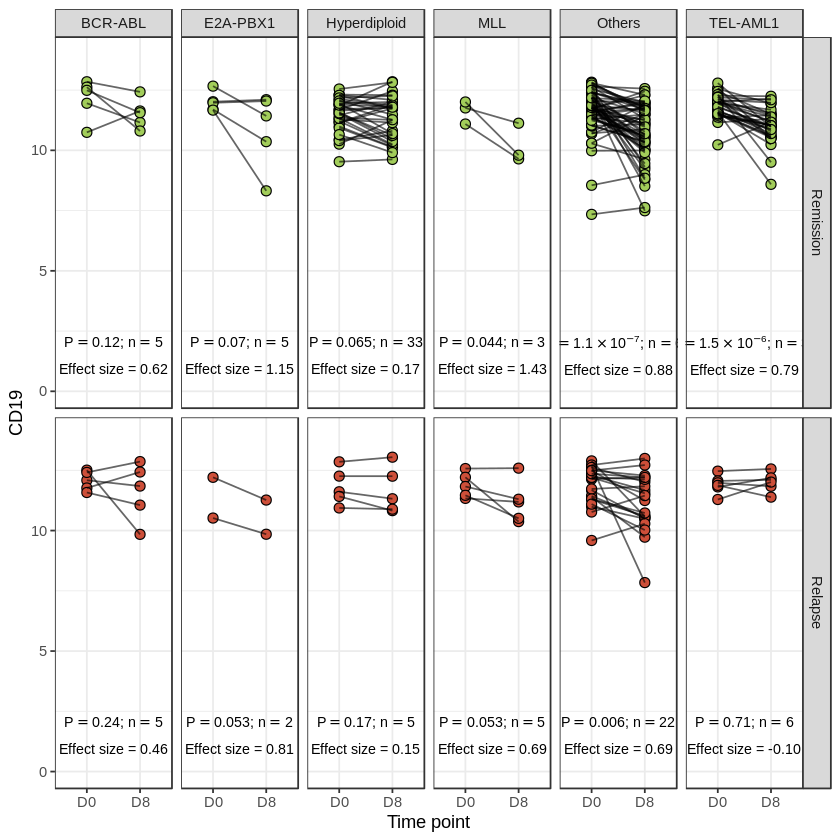

In [23]:
cd19 <- data.frame(
  t(ann_allps['CD19', , drop = F]),
  annot_all1[colnames(ann_allps), ],
  pid = substring(colnames(ann_allps), 1, 4)
)

cd19_sub <- cd19[
  cd19$class_info %in% c('D0', 'D8') &
  !(cd19$subtype %in% c('Hypodiploid', 'T-ALL')), ]

ax_paired <- ggplot(cd19_sub, aes(
  x = class_info, y = CD19, fill = outcome
)) +
  facet_grid(outcome ~ subtype) +
  geom_point(pch = 21, cex = 2.5, show.legend = F) +
  geom_line(
    aes(group = pid),
    col = 'black', alpha = .6,
    show.legend = F
  ) +
  scale_fill_manual(values = COL_LABEL) +
  labs(x = 'Time point') +
  ylim(0, 14) +
  geom_text(
    data = annot_cd19,
    x = 1.5, y = 1.5, col = 'black', cex = 3,
    aes(label = annot),
    parse = T
  )
ax_paired

# ggsave('~/Dropbox/temp/paired-CD19.pdf',
#        ax_paired, height = 4, width = 9)

### GAPDH

In [30]:
annot$label <- as.factor(annot$label)
levels(annot$label) <- c("Remission", "Relapse")

In [51]:
# GADPH: Over-expressed in cancer
## Filter out hypodiploid and T-ALL subtypes
gapdh <- ann_allps["GAPDH", , drop = F]
gapdh_y <- data.frame(
  t(gapdh),
  annot[colnames(ann_allps), ],
  pid = substring(colnames(ann_allps), 1, 4)
)

gapdh_sub <- gapdh_y[
  gapdh_y$class_info %in% c('D0', 'D8') &
  !(gapdh_y$subtype %in% c('Hypodiploid', 'T-ALL')), 
]

ax_paired <- ggplot(
  gapdh_sub,
  aes(x = class_info, y = GAPDH, fill = label)
) +
  facet_grid(label ~ subtype) +
  geom_point(pch = 21, cex = 2.5, show.legend = F) +
  geom_line(
    aes(group = pid),
    col = 'black', alpha = .6,
    show.legend = F
  ) +
  scale_fill_manual(values = COL_LABEL) +
  labs(x = 'Time point')

# ggsave('~/Dropbox/tmp/paired-GAPDH.pdf',
#        ax_paired, height = 4, width = 9)

In [61]:
gapdh_d0 <- gapdh[, endsWith(colnames(gapdh), "_D0")]
gapdh_d8 <- gapdh[, endsWith(colnames(gapdh), "_D8")]
delta <- gapdh_d0 - gapdh_d8
names(delta) <- substring(names(delta), 1, 4)

In [105]:
delta_y <- data.frame(
  t(delta),
  yeoh_label[names(delta), c("subtype", "label")]
)

ax_delta <- ggplot(
  delta_y,
  aes(label, GAPDH, col = label)
) +
  facet_wrap(~subtype, nrow = 2) +
  geom_point(position = position_jitter()) +
  scale_color_manual(values = COL_LABEL)

ggsave('~/Dropbox/tmp/delta-GAPDH.pdf',
       ax_delta, height = 5, width = 9)

### Plot: Paired t-test (mu)

In [24]:
remission_mu <- sprintf(
  'atop(paste(P == %.2g, "; ", n == %.0f), "Effect size = %.2f")',
  tab_remission[2, ],
  tab_remission[5, ],
  tab_remission[4, ]
)
relapse_mu <- sprintf(
  'atop(paste(P == %.2g, "; ", n == %.0f), "Effect size = %.2f")',
  tab_relapse[2, ],
  tab_relapse[5, ],
  tab_relapse[4, ]
)

annot_remission <- data.frame(
  annot = remission_mu,
  subtype = colnames(tab_remission),
  outcome = 'Remission',
  stringsAsFactors = F
)

annot_relapse <- data.frame(
  annot = relapse_mu,
  subtype = colnames(tab_relapse),
  outcome = 'Relapse',
  stringsAsFactors = F
)

annot_mu <- rbind(annot_remission, annot_relapse)
annot_mu[5, 1] <- sub('e-07', '%*% 10^{-7}', annot_mu[5, 1])
annot_mu$outcome <- factor(
  annot_mu$outcome,
  levels = c('Remission', 'Relapse')
)

In [25]:
bcell_cd <- data.frame(
  bcell_mean = bcell_arith_mean,
  annot_all1[names(bcell_arith_mean), ],
  pid = substring(names(bcell_arith_mean), 1, 4)
)

cd_sub <- bcell_cd[
  bcell_cd$class_info %in% c('D0', 'D8') &
  !(bcell_cd$subtype %in% c('Hypodiploid', 'T-ALL')), ]

ax_paired <- ggplot(cd_sub, aes(
  x = class_info, y = bcell_mean, fill = outcome
)) +
  facet_grid(outcome ~ subtype) +
  geom_point(pch = 21, cex = 2.5, show.legend = F) +
  geom_line(
    aes(group = pid),
    col = 'black', alpha = .6, show.legend = F
  ) +
  scale_fill_manual(values = COL_LABEL) +
  labs(x = 'Time point', y = quote(mu)) +
  ylim(0, 14) +
  geom_text(
    data = annot_mu,
    x = 1.5, y = 1.5, col = 'black', cex = 3,
    aes(label = annot),
    parse = T
  )

# ggsave('~/Dropbox/temp/paired-mu.pdf', ax_paired,
#        height = 4, width = 9)

In [ ]:
# # Selecting D8 and D33 patients
# idx <- annot_all[colnames(all_cd), "class_info"] %in% c('D8', 'D33')
# hvg_cd_d33 <- select_hvg(all_cd[, idx], 30)

# heatmap_annot1 <- annot_all[, c('subtype', 'label', 'class_info')]

## Plot: Paired D33

In [252]:
complete_pid <- substring(
  rownames(bcell_mean)[endsWith(rownames(bcell_mean), 'D33')],
  1, 4)

# Subset only patients that have complete timepoints
complete_sid <- rownames(bcell_mean)[
  substring(rownames(bcell_mean), 1, 4) %in% pid_complete]

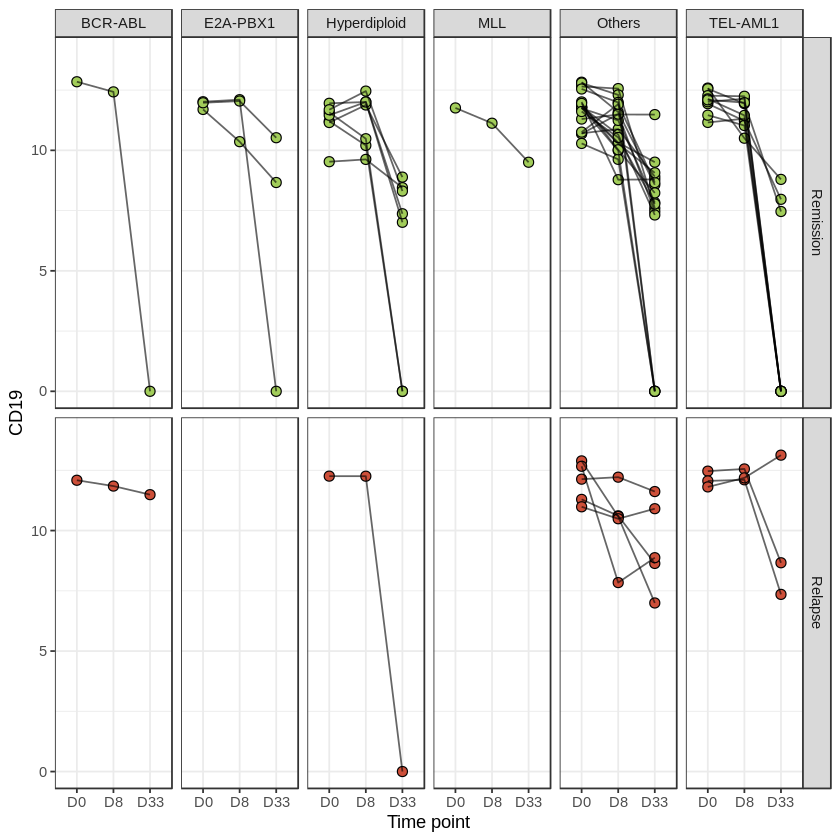

In [27]:
cd19 <- data.frame(
  t(ann_allyeoh_allps['CD19', , drop = F]),
  annot_all1[colnames(ann_allyeoh_allps), ],
  pid = substring(colnames(ann_allyeoh_allps), 1, 4)
)

complete_cd19 <- cd19[complete_sid, ]

complete_cd19_sub <- complete_cd19[
  !(complete_cd19$subtype %in% c('Hypodiploid', 'T-ALL')), ]

ax_paired <- ggplot(complete_cd19_sub, aes(
  x = class_info, y = CD19, fill = outcome
)) +
  facet_grid(outcome ~ subtype) +
  geom_point(pch = 21, cex = 2.5, show.legend = F) +
  geom_line(
    aes(group = pid),
    col = 'black', alpha = .6,
    show.legend = F
  ) +
  scale_fill_manual(values = COL_LABEL) +
  labs(x = 'Time point') +
  ylim(0, 14)

ax_paired

# ggsave('~/Dropbox/tmp/paired_d33-cd19.pdf', ax_paired,
#       width = 9, height = 4)

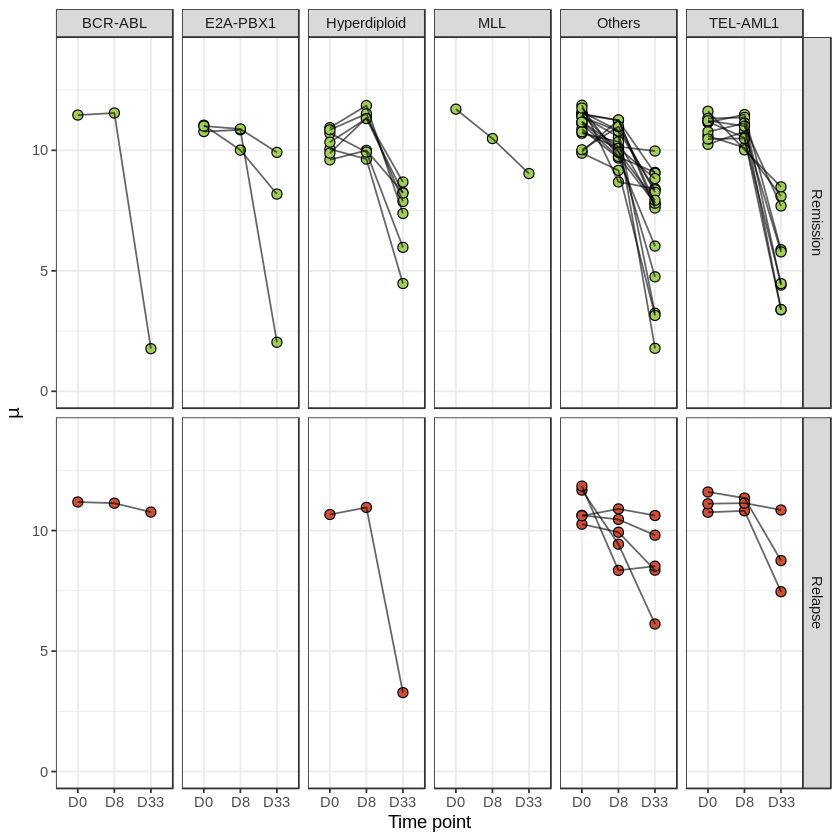

In [381]:
bcell_mu <- data.frame(
  bcell_mean = bcell_arith_mean,
  annot_all1[names(bcell_arith_mean), ],
  pid = substring(names(bcell_arith_mean), 1, 4)
)

bcell_mu_sub <- bcell_mu[
  !(bcell_mu$subtype %in% c('Hypodiploid', 'T-ALL')), ]

complete_mu <- bcell_mu[complete_sid, ]

complete_mu_sub <- complete_mu[
  !(complete_mu$subtype %in% c('Hypodiploid', 'T-ALL')), ]

ax_paired <- ggplot(complete_mu_sub, aes(
  x = class_info, y = bcell_mean, fill = outcome
)) +
  facet_grid(outcome ~ subtype) +
  geom_point(pch = 21, cex = 2.5, show.legend = F) +
  geom_line(
    aes(group = pid),
    col = 'black', alpha = .6, show.legend = F
  ) +
  scale_fill_manual(values = COL_LABEL) +
  labs(x = 'Time point', y = quote(mu)) +
  ylim(0, 14)

ax_paired

# ggsave('~/Dropbox/tmp/paired_d33-mu.pdf', ax_paired,
#        height = 4, width = 9)

## Deltas

#### CD19

In [236]:
d0_cd19 <- complete_cd19_sub[
  endsWith(rownames(complete_cd19_sub), '_D0'), 'CD19']
d8_cd19 <- complete_cd19_sub[
  endsWith(rownames(complete_cd19_sub), '_D8'), 'CD19']
d33_cd19 <- complete_cd19_sub[
  endsWith(rownames(complete_cd19_sub), '_D33'), 'CD19']

In [335]:
t_1 <- 8
t_2 <- 33 - 8
gamma_1 <- d0_cd19 - d8_cd19
gamma_2 <- d8_cd19 - d33_cd19
delta_1 <- (d0_cd19 - d8_cd19) / t_1
delta_2 <- (d8_cd19 - d33_cd19) / t_2

delta_cd19 <- data.frame(
  gamma_1,
  gamma_2,
  delta_1,
  delta_2,
  D0 = d0_cd19,
  D8 = d8_cd19,
  D33 = d33_cd19
)
pid <- substring(
  rownames(complete_cd19_sub)[
    endsWith(rownames(complete_cd19_sub), '_D0')],
  1, 4
)
rownames(delta_cd19) <- pid

#### Investigate: Normalising deltas

In [342]:
delta_cd19$delta_1_D0 <- delta_cd19$delta_1 / delta_cd19$D0
delta_cd19$delta_1_D8 <- delta_cd19$delta_1 / delta_cd19$D8
delta_cd19$delta_2_D8 <- delta_cd19$delta_2 / delta_cd19$D8
delta_cd19$delta_2_D33 <- delta_cd19$delta_2 / delta_cd19$D33

delta_cd19$gamma_1_D0 <- delta_cd19$gamma_1 / delta_cd19$D0
delta_cd19$gamma_1_D8 <- delta_cd19$gamma_1 / delta_cd19$D8
delta_cd19$gamma_2_D8 <- delta_cd19$gamma_2 / delta_cd19$D8
delta_cd19$gamma_2_D33 <- delta_cd19$gamma_2 / delta_cd19$D33

In [343]:
delta_cd19$pid <- rownames(delta_cd19)
delta_cd19_y <- cbind(
  delta_cd19,
  yeoh_label[rownames(delta_cd19), c('subtype', 'label')]
)
delta_cd19_long <- melt(delta_cd19_y)

Using pid, subtype, label as id variables


In [271]:
# ax_delta <- ggplot(delta_cd19_long, aes(variable, value, fill = label)) +
#   facet_grid(label ~ subtype) +
#   geom_point(pch = 21) +
#   geom_line(aes(group = pid), alpha = 0.6) +
#   scale_fill_manual(values = COL_LABEL)

# ggsave('~/Dropbox/tmp/delta2-cd19.pdf', ax_delta,
#        width = 9, height = 4)

### Rate v.s. Starting / remaining proportion

In [321]:
# ax_vs <- ggplot(
#   delta_cd19_y,
#   aes(x = D33, y = delta_2, fill = label)
# ) +
#   facet_wrap(~subtype, nrow = 2) +
#   geom_point(pch = 21, cex = 3) +
#   scale_fill_manual(values = COL_LABEL)

# ggsave('~/Dropbox/tmp/delta_2-D33.pdf', ax_vs,
#        width = 9 , height = 6)

In [345]:
ax_jitter <- ggplot(
  delta_cd19_y,
  aes(x = label, y = gamma_1_D8, fill = label)
) +
  facet_wrap(~subtype, nrow = 1) +
  geom_point(pch = 21, cex = 2, position = position_jitter(width = .3)) +
  scale_fill_manual(values = COL_LABEL)

ggsave('~/Dropbox/tmp/jitter-gamma_1_D8.pdf', ax_jitter,
       width = 9 , height = 3)

#### CD: Mean

In [354]:
d0_mu <- complete_mu_sub[
  endsWith(rownames(complete_mu_sub), '_D0'),
  'bcell_mean']
d8_mu <- complete_mu_sub[
  endsWith(rownames(complete_mu_sub), '_D8'),
  'bcell_mean']
d33_mu <- complete_mu_sub[
  endsWith(rownames(complete_mu_sub), '_D33'),
  'bcell_mean']

In [360]:
t_1 <- 8
t_2 <- 33 - 8
gamma_mu_1 <- d0_mu - d8_mu
gamma_mu_2 <- d8_mu - d33_mu
delta_mu_1 <- (d0_mu - d8_mu) / t_1
delta_mu_2 <- (d8_mu - d33_mu) / t_2

delta_mu <- data.frame(
  gamma_mu_1,
  gamma_mu_2,
  delta_mu_1,
  delta_mu_2,
  D0 = d0_mu,
  D8 = d8_mu,
  D33 = d33_mu
)

pid <- substring(
  rownames(complete_mu_sub)[
    endsWith(rownames(complete_mu_sub), '_D0')],
  1, 4
)
rownames(delta_mu) <- pid

In [365]:
delta_mu$delta_1_D0 <- delta_mu$delta_mu_1 / delta_mu$D0
delta_mu$delta_1_D8 <- delta_mu$delta_mu_1 / delta_mu$D8
delta_mu$delta_2_D8 <- delta_mu$delta_mu_2 / delta_mu$D8
delta_mu$delta_2_D33 <- delta_mu$delta_mu_2 / delta_mu$D33

delta_mu$gamma_1_D0 <- delta_mu$gamma_mu_1 / delta_mu$D0
delta_mu$gamma_1_D8 <- delta_mu$gamma_mu_1 / delta_mu$D8
delta_mu$gamma_2_D8 <- delta_mu$gamma_mu_2 / delta_mu$D8
delta_mu$gamma_2_D33 <- delta_mu$gamma_mu_2 / delta_mu$D33

In [366]:
delta_mu$pid <- rownames(delta_mu)
delta_mu_y <- cbind(
  delta_mu,
  yeoh_label[rownames(delta_mu), c('subtype', 'label')])
delta_mu_long <- melt(delta_mu_y)

Using pid, subtype, label as id variables


In [65]:
# ax_delta <- ggplot(delta_mu_long, aes(variable, value, fill = label)) +
#   facet_grid(label ~ subtype) +
#   geom_point(pch = 21) +
#   geom_line(aes(group = pid), alpha = 0.6) +
#   scale_fill_manual(values = COL_LABEL)

# ggsave('~/Dropbox/tmp/delta2-mu.pdf', ax_delta,
#        width = 9, height = 4)

In [372]:
# Jitter plots
ax_jitter <- ggplot(
  delta_mu_y,
  aes(x = label, y = gamma_2_D33, fill = label)
) +
  facet_wrap(~subtype, nrow = 1) +
  geom_point(pch = 21, cex = 2, position = position_jitter(width = .3)) +
  scale_fill_manual(values = COL_LABEL)

ggsave('~/Dropbox/tmp/jitter_mu-gamma_2_D33.pdf', ax_jitter,
       width = 9 , height = 3)

In [377]:
# Versus plots
ax_vs <- ggplot(
  delta_mu_y,
  aes(x = D0, y = gamma_mu_1, fill = label)
) +
  facet_wrap(~subtype, nrow = 2) +
  geom_point(pch = 21, cex = 3) +
  scale_fill_manual(values = COL_LABEL)

ggsave('~/Dropbox/tmp/gamma_mu_1-D0.pdf', ax_vs,
       width = 9 , height = 6)

#### Compare deltas of remission and relapse

In [66]:
ax <- ggplot(delta_cd19_y, aes(label, delta_2, fill = label)) +
  facet_wrap(~subtype, nrow = 1) +
  geom_point(position = position_jitter(w = .2), pch = 21) +
  scale_fill_manual(values = COL_LABEL)

ggsave('~/Dropbox/tmp/jitter-delta_cd19.pdf', ax, width = 9, height = 3)

In [67]:
ax <- ggplot(delta_mu_y, aes(label, delta_2, fill = label)) +
  facet_wrap(~subtype, nrow = 1) +
  geom_point(position = position_jitter(w = .2), pch = 21) +
  scale_fill_manual(values = COL_LABEL)

ggsave('~/Dropbox/tmp/jitter-delta_mu.pdf', ax, width = 9, height = 3)

#### All patients

In [389]:
d0_mu <- bcell_mu_sub[
  endsWith(rownames(bcell_mu_sub), '_D0'),
  'bcell_mean']
d8_mu <- bcell_mu_sub[
  endsWith(rownames(bcell_mu_sub), '_D8'),
  'bcell_mean']

t_1 <- 8
gamma_mu_1 <- d0_mu - d8_mu
delta_mu_1 <- (d0_mu - d8_mu) / t_1

delta_mu <- data.frame(
  gamma_mu_1,
  delta_mu_1,
  D0 = d0_mu,
  D8 = d8_mu
)

pid <- substring(
  rownames(bcell_mu_sub)[
    endsWith(rownames(bcell_mu_sub), '_D0')
  ], 1, 4
)
rownames(delta_mu) <- pid

delta_mu$delta_1_D0 <- delta_mu$delta_mu_1 / delta_mu$D0
delta_mu$delta_1_D8 <- delta_mu$delta_mu_1 / delta_mu$D8

delta_mu$gamma_1_D0 <- delta_mu$gamma_mu_1 / delta_mu$D0
delta_mu$gamma_1_D8 <- delta_mu$gamma_mu_1 / delta_mu$D8

delta_mu$pid <- rownames(delta_mu)
delta_mu_y <- cbind(
  delta_mu,
  yeoh_label[rownames(delta_mu), c('subtype', 'label')]
)

In [399]:
ax <- ggplot(
  delta_mu_y,
  aes(label, gamma_1_D0, fill = label)
) +
  facet_wrap(~subtype, nrow = 1) +
  geom_point(position = position_jitter(width = .2), pch = 21) +
  scale_fill_manual(values = COL_LABEL)

ggsave('~/Dropbox/tmp/jitter_mu_all-gamma_1_D0.pdf', ax,
       width = 9, height = 3)

## Count: Highly expressed genes

In [193]:
complete_data <- allyeoh[
  , c(complete_sid, c('N01', 'N02', 'N04'))]
threshold <- 12
pct <- colSums(complete_data > threshold) / nrow(complete_data)

In [214]:
timepoint <- c(
  substring(names(pct)[1:(length(pct) - 3)], 6),
  rep('D0', 3))

high_expr <- data.frame(
  pid = substring(names(pct), 1, 4),
  timepoint,
  annot_all[names(pct), c('subtype', 'label')],
  pct
)
high_expr$timepoint <- factor(
  high_expr$timepoint,
  levels = c('D0', 'D8', 'D33')
)

ax_pct <- ggplot(high_expr, aes(timepoint, pct, fill = label)) +
  facet_grid(label ~ subtype) +
  geom_point(pch = 21) +
  geom_line(aes(group = pid), alpha = 0.6) +
  scale_fill_manual(values = COL_LABEL)

# ggsave('~/Dropbox/tmp/pct-10.pdf', ax_pct, width = 9, height = 4)

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?


#### Plot: Single markers

In [1220]:
# for (i in seq_len(nrow(bcell_sub1))) {
#   cd <- data.frame(
#     t(bcell_sub1[i, ]),
#     annot_all[colnames(bcell_sub1), ]
#   )

#   cd_gene <- colnames(cd)[1]
#   jitter_cd <- ggplot(
#     cd,
#     aes_string(x = 'class_info', y = cd_gene, col = 'label')
#   ) +
#     geom_point(
#       position = position_jitterdodge(),
#       alpha = 0.6
#     ) +
#     facet_wrap(~subtype, nrow = 2) +
#     scale_color_manual(values = COL_LABEL) +
#     ylim(0, 16)

#   wpath <- sprintf('~/Dropbox/temp/jitter-%s.pdf', cd_gene)
#   ggsave(wpath, jitter_cd, width = 8, height = 5.5)
# }

#### D33 patients

In [1081]:
# Selecting D8 and D33 patients
idx <- annot_all[colnames(all_cd), "class_info"] %in% c('D8', 'D33')
hvg_cd_d33 <- select_hvg(all_cd[, idx], 30)

heatmap_annot1 <- annot_all[, c('subtype', 'label', 'class_info')]

pheatmap(
  hvg_cd_d33, col = brewer.pal(n = 11, name = "RdBu"), # col = brewer.pal(9, "Blues"),
  display_numbers = F, legend = T, border_color = NA,
  scale = "row",
  cluster_method = "ward.D2", cluster_rows = T, cluster_cols = T,
#   cutree_cols = 4,
  annotation_col = heatmap_annot1,
  show_colnames = F, show_rownames = T,
  fontsize = 12, cellwidth = 4, cellheight = 12,
  filename = "~/Dropbox/temp/heatmap-hvg_cd_d33.pdf"
)

In [1077]:
# Selecting D8 and D33 patients
idx <- annot_all[colnames(all_cd), "class_info"] %in% c('D8', 'D33')
lit_cd_d33 <- all_cd[impt_cd, idx]

heatmap_annot1 <- annot_all[, c('subtype', 'label', 'class_info')]

pheatmap(
  lit_cd_d33, col = brewer.pal(n = 11, name = "RdBu"), # col = brewer.pal(9, "Blues"),
  display_numbers = F, legend = T, border_color = NA,
  scale = "row",
  cluster_method = "ward.D2", cluster_rows = T, cluster_cols = T,
#   cutree_cols = 4,
  annotation_col = heatmap_annot1,
  show_colnames = F, show_rownames = T,
  fontsize = 12, cellwidth = 2, cellheight = 30,
  filename = "~/Dropbox/temp/heatmap-lit_cd_d33.pdf"
)

In [59]:
# # Unofficial T-cell markers
# t_markers <- c(
#   'CD7', 'CD96', 'CD160', 'CD28', 'CD8A', 'CD247',
#   'CD6', 'CD1A', 'CD1D', 'CD1E', 'CD3G', 'CD14'
# )

# avg_tmarker <- colMeans(all_cd[t_markers, ])

# # plot against label, mrd
# avgt_y <- data.frame(
#   avg_tmarker,
#   annot_all[names(avg_tmarker), ]
# )
# head(avgt_y)

# jitter_avgt <- ggplot(
#   avgt_y,
#   aes(x = class_info, y = avg_tmarker, col = label)
# ) +
#   geom_point(
#     position = position_jitterdodge(),
#     alpha = 0.6
#   ) +
#   facet_wrap(~subtype, nrow = 2) +
#   scale_color_manual(values = COL_LABEL)

# ggsave('~/Dropbox/temp/jitter-t_markers.pdf',
#        jitter_avgt, width = 8, height = 4)

# CIBERSORT

In [163]:
# Output: Annotated non-log expression matrix
path <- 'tmp/cibersort-LM22.txt'
lm22 <- read.table(path, sep = "\t", header = T, row.names = 1)

In [90]:
#' Find similar genes to vector of gene symbols
#' @return named list with gene symbols in x as names and
#' matching gene symbols in y as values
get_similar_genes <- function(x, y) {
  # Default value of gene with no match is NULL
  matched_genes <- vector("list", length(x))
  names(matched_genes) <- x
  
  idx_notequiv <- !(x %in% y)
  not_equiv <- x[idx_notequiv]
  idx_mult <- grepl("///", not_equiv)
  
  matched_singles <- lapply(
    not_equiv[!idx_mult],
    grep, x = y, value = T
  )
  names(matched_singles) <- not_equiv[!idx_mult]
  matched_singles_fltr <- Filter(
    function(x) ifelse(length(x) == 0, F, T),
    matched_singles
  )

  mult_symbols <- lapply(
    not_equiv[idx_mult],
    function(x) unlist(strsplit(x, " /// "))
  )
  names(mult_symbols) <- not_equiv[idx_mult]
  matched_mults <- lapply(
    mult_symbols,
    function(x) unlist(lapply(x, grep, x = y, value = T))
  )
  matched_mults_fltr <- Filter(
    function(x) ifelse(length(x) == 0, F, T),
    matched_mults
  )
  
  # initialise list with equivalent genes
  matched_genes[!idx_notequiv] <- x[!idx_notequiv]
  # replace similar singles and multiples
  matched_genes[names(matched_singles_fltr)] <- matched_singles_fltr
  matched_genes[names(matched_mults_fltr)] <- matched_mults_fltr

  matched_genes
}

In [131]:
absent_signature <- rownames(lm22)[
  !(rownames(lm22) %in% rownames(ann_allyeoh_allps))]

absent_mapping <- get_similar_genes(
  absent_signature, rownames(ann_allyeoh_allps))

In [132]:
# Remove ambiguous gene (last item in list)
# Remove genes with no matching genes
absent_mapping <- Filter(function(x) !is.null(x), absent_mapping[1:29])   
# First match of multiple is the correct one
absent_mapping <- lapply(
  absent_mapping,
  function(x) ifelse(length(x) > 1, x[1], x)
)
# Replace ambiguous probe set with lm22 signature in annotated data set
rownames(ann_allyeoh_allps)[
  match(absent_mapping, rownames(ann_allyeoh_allps))
] <- names(absent_mapping)

In [161]:
present_genes <- rownames(lm22)[
  rownames(lm22) %in% rownames(ann_allyeoh_allps)]
# Only select genes that are present in LM22
allyeoh_cibersort <- ann_allyeoh_allps[present_genes, ]

# Power to 2, aside from 0 values
nonlog_cibersort <- allyeoh_cibersort
nonlog_cibersort[nonlog_cibersort != 0] <-
  (2 ^ nonlog_cibersort)[nonlog_cibersort != 0]
nonlog_cibersort <- cbind(
  GeneSymbol = rownames(nonlog_cibersort),
  nonlog_cibersort
)

In [162]:
write.table(
  nonlog_cibersort,
  '~/Dropbox/tmp/data-cibersort.tsv',
  quote = F, sep = '\t', row.names = F
)

#### CIBERSORT output

In [187]:
path1 <- 'tmp/cibersort-output_wo_quantile.txt'
path2 <- 'tmp/cibersort-output_quantile.txt'
cibersort_wo_quantile <- t(read.table(path1, sep = "\t", header = T, row.names = 1))
cibersort_quantile <- t(read.table(path2, sep = "\t", header = T, row.names = 1))

In [188]:
cibersort_wo <- cibersort_wo_quantile[1:22, ]
cibersort <- cibersort_quantile[1:22, ]
heatmap_annot <- annot_all[, 2:4]

pheatmap(
  cibersort_wo,
#   col = brewer.pal(n = 11, name = "RdBu"),
  col = brewer.pal(9, "Blues"),
  display_numbers = F, legend = T, border_color = NULL,
  cluster_method = "ward.D2", cluster_rows = T, cluster_cols = T,
  scale = "none", show_colnames = F, show_rownames = T,
  annotation_col = heatmap_annot,
  fontsize = 10, cellwidth = 1, cellheight = 15,
  filename = "~/Dropbox/tmp/heatmap-cibersort_wo.pdf"
)

pheatmap(
  cibersort,
#   col = brewer.pal(n = 11, name = "RdBu"),
  col = brewer.pal(9, "Blues"),
  display_numbers = F, legend = T, border_color = NULL,
  cluster_method = "ward.D2", cluster_rows = T, cluster_cols = T,
  scale = "none", show_colnames = F, show_rownames = T,
  annotation_col = heatmap_annot,
  fontsize = 10, cellwidth = 1, cellheight = 15,
  filename = "~/Dropbox/tmp/heatmap-cibersort.pdf"
)

In [403]:
complete_sid

[1] "P013_D0"  "P016_D0"  "P017_D0"  "P018_D0"  "P019_D0"  "P024_D0" 
  [7] "P026_D0"  "P027_D0"  "P028_D0"  "P029_D0"  "P036_D0"  "P037_D0" 
 [13] "P038_D0"  "P039_D0"  "P041_D0"  "P042_D0"  "P043_D0"  "P046_D0" 
 [19] "P048_D0"  "P049_D0"  "P050_D0"  "P051_D0"  "P053_D0"  "P057_D0" 
 [25] "P058_D0"  "P060_D0"  "P061_D0"  "P062_D0"  "P063_D0"  "P064_D0" 
 [31] "P065_D0"  "P067_D0"  "P070_D0"  "P073_D0"  "P075_D0"  "P076_D0" 
 [37] "P078_D0"  "P080_D0"  "P081_D0"  "P082_D0"  "P083_D0"  "P084_D0" 
 [43] "P085_D0"  "P086_D0"  "P087_D0"  "P088_D0"  "P092_D0"  "P093_D0" 
 [49] "P094_D0"  "P013_D8"  "P016_D8"  "P017_D8"  "P018_D8"  "P019_D8" 
 [55] "P024_D8"  "P026_D8"  "P027_D8"  "P028_D8"  "P029_D8"  "P036_D8" 
 [61] "P037_D8"  "P038_D8"  "P039_D8"  "P041_D8"  "P042_D8"  "P043_D8" 
 [67] "P046_D8"  "P048_D8"  "P049_D8"  "P050_D8"  "P051_D8"  "P053_D8" 
 [73] "P057_D8"  "P058_D8"  "P060_D8"  "P061_D8"  "P062_D8"  "P063_D8" 
 [79] "P064_D8"  "P065_D8"  "P067_D8"  "P070_D8"  "P073_D8"  "P075_D8" 
 [85] "P076_D8"  "P078_D8"  "P080_D8"  "P081_D8"  "P082_D8"  "P083_D8" 
 [91] "P084_D8"  "P085_D8"  "P086_D8"  "P087_D8"  "P088_D8"  "P092_D8" 
 [97] "P093_D8"  "P094_D8"  "P013_D33" "P016_D33" "P017_D33" "P018_D33"
[103] "P019_D33" "P024_D33" "P026_D33" "P027_D33" "P028_D33" "P029_D33"
[109] "P036_D33" "P037_D33" "P038_D33" "P039_D33" "P041_D33" "P042_D33"
[115] "P043_D33" "P046_D33" "P048_D33" "P049_D33" "P050_D33" "P051_D33"
[121] "P053_D33" "P057_D33" "P058_D33" "P060_D33" "P061_D33" "P062_D33"
[127] "P063_D33" "P064_D33" "P065_D33" "P067_D33" "P070_D33" "P073_D33"
[133] "P075_D33" "P076_D33" "P078_D33" "P080_D33" "P081_D33" "P082_D33"
[139] "P083_D33" "P084_D33" "P085_D33" "P086_D33" "P087_D33" "P088_D33"
[145] "P092_D33" "P093_D33" "P094_D33"

In [ ]:
cibersort_wo_bcells <- data.frame(
  t(cibersort_wo['B.cells.naive', , drop = F]),
  annot_all[colnames(cibersort_wo), ],
  pid = substring(colnames(cibersort_wo), 1, 4)
)

In [213]:
idx <- endsWith(rownames(cibersort_wo_bcells), 'D0') |
  endsWith(rownames(cibersort_wo_bcells), 'D8')
complete_cibersort_wo <- cibersort_wo_bcells[idx, ]

cibersort_wo_bcells_sub <- complete_cibersort_wo[
  !(complete_cibersort_wo$subtype %in% c('Hypodiploid', 'T-ALL')), ]

ax_paired <- ggplot(
  cibersort_wo_bcells_sub,
  aes(x = class_info, y = B.cells.naive, fill = label)
) +
  facet_grid(label ~ subtype) +
  geom_point(pch = 21, cex = 2.5, show.legend = F) +
  geom_line(
    aes(group = pid),
    col = 'black', alpha = .6,
    show.legend = F
  ) +
  scale_fill_manual(values = COL_LABEL) +
  labs(x = 'Time point') +
  ylim(0, 1)

# ggsave('~/Dropbox/tmp/paired_bcells-cibersort_wo_quantile.pdf', ax_paired,
#       width = 9, height = 4)

In [407]:
# D0 - D8 - D33 plots
d33_cibersort <- cibersort_wo_bcells[complete_sid, ]
d33_cibersort_sub <- d33_cibersort[
  !(d33_cibersort$subtype %in% c('Hypodiploid', 'T-ALL')), ]

ax_paired <- ggplot(
  d33_cibersort_sub,
  aes(x = class_info, y = B.cells.naive, fill = label)
) +
  facet_grid(label ~ subtype) +
  geom_point(pch = 21, cex = 2.5, show.legend = F) +
  geom_line(
    aes(group = pid),
    col = 'black', alpha = .6,
    show.legend = F
  ) +
  scale_fill_manual(values = COL_LABEL) +
  labs(x = 'Time point') +
  ylim(0, 1)

ggsave('~/Dropbox/tmp/cibersort-paired_d33.pdf', ax_paired,
       width = 9, height = 4)

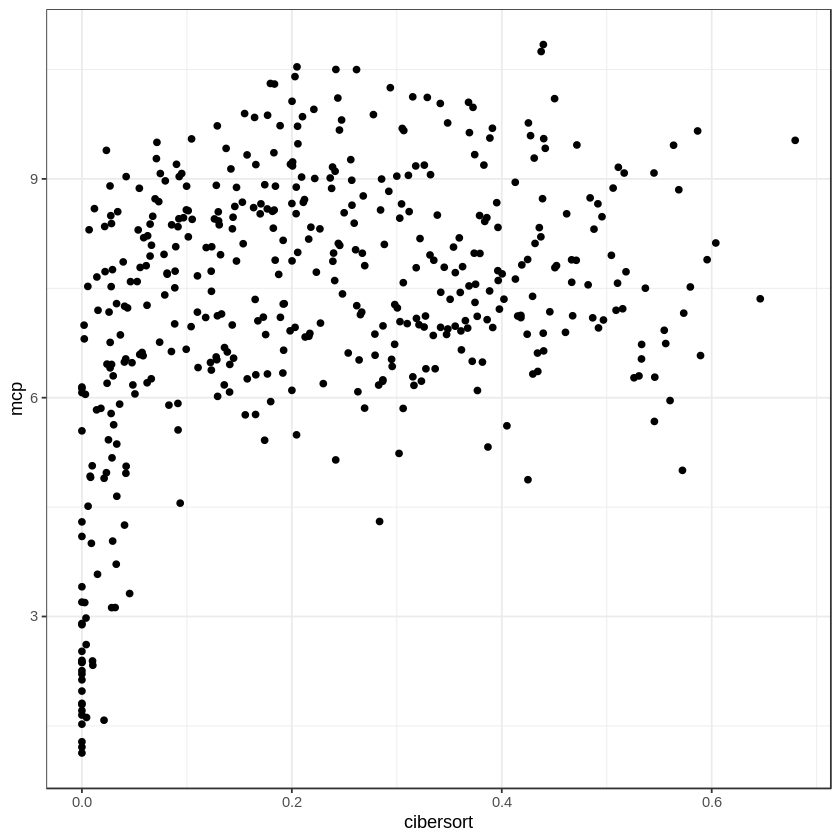

In [417]:
deconvolution <- data.frame(
  cibersort = cibersort_wo_bcells$B.cells.naive,
  mcp = mcp_b
)

ggplot(
  deconvolution,
  aes(cibersort, mcp)
) +
  geom_point()

## MCP-counter

In [7]:
library(MCPcounter)

Loading required package: curl


In [54]:
# path <- "tmp/mcpcounter_genes.txt"
# mcp_genes <- read.table(path, sep = "\t", header = T)

path1 <- "data/leuk_D33/processed/mas5_filtered.tsv"
path2 <- "data/GSE67684/processed/metadata/sid-metadata_v1.tsv"

annot_all <- read.table(path2, sep = "\t", header = T)
annot_all[] <- lapply(annot_all, as.factor)
annot_all$class_info <- factor(
  annot_all$class_info,
  c('D0', 'D8', 'D33', 'N')
) # Re-order levels

yeoh_d33 <- read.table(path1, sep = "\t", header = T)
yeoh_d33_1 <- log2_transform(normaliseMeanScaling(yeoh_d33))
yeoh_all <- cbind(yeoh_allps, yeoh_d33_1)
missing_samples <- colnames(yeoh_all)[!(colnames(yeoh_all) %in% rownames(annot_all))]
yeoh_all1 <- yeoh_all[, !(colnames(yeoh_all) %in% missing_samples)]

mcp_estimate <- MCPcounter.estimate(yeoh_all1, featuresType = "affy133P2_probesets")

P001_D33 P006_D33 P007_D33 P008_D33 P009_D33 P010_D33 
2.106859 2.132480 1.498776 2.559182 1.576584 2.657973 


In [55]:
cell_pop <- cbind(
  annot_all[colnames(mcp_estimate), c("subtype", "class_info", "label")],
  b_lineage = mcp_estimate["B lineage", ]
)
cell_pop$class_info <- factor(
  cell_pop$class_info,
  levels = c("D0", "D8", "D33", "N")
)

ax_jitter <- ggplot(
  cell_pop,
  aes(x = class_info, y = b_lineage, fill = label)
) +
  facet_wrap(~subtype, scales = "free_x", nrow = 3) +
  geom_point(
    position = position_jitterdodge(),
    pch = 21, cex = 2.5, show.legend = F
  ) +
  labs(x = "Time point", y = "MCP-counter scores (B lineage)") +
  scale_fill_manual(values = COL_LABEL)

In [58]:
path <- "~/Dropbox/tmp/jitter-mcp_blineage.pdf"
ggsave(path, ax_jitter, width = 7, height = 7)

#### Goh (2019): SPS genes
- Super proliferative set
- Obtained from intersection of 48 sets of breast cancer signatures

In [804]:
GOH_RPATH <- "data/goh_2019/goh_signatures.tsv"
genes_tab <- read.table(GOH_RPATH, sep = "\t", header = T)
goh_genes <- genes_tab[, 1]

In [809]:
ENTREZ_GPL570 <- "../info/microarray/HG-U133_Plus_2/annot_entrez-GPL570.tsv"
entrez_yeoh <- affy2id(yeoh_unfltr, ENTREZ_GPL570)

No. of probesets with no ID removed: 1010
Total no. of probesets removed (incl. probesets mapping to same gene): 2764


In [815]:
sps_yeoh <- entrez_yeoh[rownames(entrez_yeoh) %in% goh_genes, ]

In [824]:
# # All D0 samples
# ayeoh_fltr <- ann_yeoh[
#   gene_signatures,
#   Y[colnames(ann_yeoh), "class_info"] == "D0"
# ]
# ayeoh_fltr <- ayeoh_fltr[rowSums(ayeoh_fltr) != 0, ]

# heatmap_annot <- Y[, c("batch_info", "label", "subtype"), drop = F]
# heatmap_annot$batch_info <- as.double(heatmap_annot$batch_info)

sps_hmap <- pheatmap(
  sps_yeoh,
  col = brewer.pal(n = 11, name = "RdBu"),
#   col = brewer.pal(9, "Blues"),
  display_numbers = F, legend = T, border_color = NULL,
  cluster_method = "ward.D2", cluster_rows = T, cluster_cols = T,
#   cutree_cols = 4,
  scale = "row", show_colnames = F, show_rownames = F,
  annotation_col = Y,
  fontsize = 3, cellwidth = 2, cellheight = 5,
  filename = "~/Dropbox/temp/heatmap-sps_signatures.pdf"
)

#### Gu (2019): Important genes

In [45]:
# # rename DUX4 gene
# rownames(ann_yeoh)[grepl("DUX4", rownames(ann_yeoh))] <- "DUX4"
# impt_genes <- c("DUX4", "PAX5", "IKZF1", "ERG", "IGH", "CDKN2A", "ZNF384")
# yeoh_impt <- ann_yeoh[impt_genes, ]

## B-ALL "Others" subtypes
- DUX4
    - Overexpression of DUX4
    - Characterised by recurrent IGH-DUX4 or ERG-DUX4 fusions
    - Frequently co-occurring with intragenic ERG deletions
- PAX5alt
    - PAX5 as a driver mutation
    - Commonly have co-deletion of IKZF1 and CDKN2A/B
    - If IKZF1 is deleted, poor outcome. Otherwise, excellent prognosis
- ETV6-RUNX1-like
    - ETV6 and IKZF1 alterations
    - IKZF1 alterations did not result in poor prognosis, unlike other cases in B-ALL
- ZNF384-like
- BCR-ABL1-like
    - No CRLF2 rearrangement

#### Others (D0)

In [46]:
others_d0 <- others[Y[colnames(others), "class_info"] == "D0"]
# exclude batch effect genes
others_d0_wo_batch <- others_d0[!(rownames(others_d0) %in% batch_genes), ]
others_d0_hvg300 <- select_hvg(others_d0_wo_batch, 300)

In [47]:
# # Hierarchical clustering
# # heatmap_annot$batch_info <- as.double(heatmap_annot$batch_info)
# # DUX4 gene expression is zero for all samples
# impt_genes <- t(yeoh_impt[
#   rownames(yeoh_impt) != "DUX4",
#   rownames(heatmap_annot)
# ])
# annot2 <- cbind(heatmap_annot, impt_genes)

# # others_clust <- pheatmap(
# #   others_d0_hvg300, col = brewer.pal(n = 11, name = "RdBu"), # col = brewer.pal(9, "Blues"),
# #   display_numbers = F,
# #   legend = T, border_color = "black", scale = "row",
# #   cluster_method = "ward.D2", cluster_rows = T, cluster_cols = T,
# # #   cutree_cols = 4,
# #   show_colnames = T, show_rownames = F,
# #   annotation_col = annot2,
# #   fontsize = 10,
# #   cellwidth = 12, cellheight = 2,
# #   filename = "~/Dropbox/temp/heatmap-others_300hvg.pdf"
# # )

#### All (D0)

In [175]:
# # exclude batch effect genes
# d0_wo_batch <- data[
#   !(rownames(data) %in% batch_genes),
#   Y[colnames(data), "class_info"] == "D0"
# ]
# d0_hvg300 <- select_hvg(d0_wo_batch, 500)

In [ ]:
# # hierarchical clustering
# # tweak method and distance
# heatmap_annot <- Y[, c("batch_info", "label", "subtype"), drop = F]
# # heatmap_annot$batch_info <- as.double(heatmap_annot$batch_info)
# # DUX4 gene expression is zero for all samples
# impt_genes <- t(yeoh_impt[
#   rownames(yeoh_impt) != "DUX4",
#   rownames(heatmap_annot)
# ])
# annot2 <- cbind(heatmap_annot, impt_genes)

# others_clust <- pheatmap(
#   d0_hvg300, col = brewer.pal(n = 11, name = "RdBu"), # col = brewer.pal(9, "Blues"),
#   display_numbers = F,
#   legend = T, border_color = "black", scale = "row",
#   cluster_method = "ward.D2", cluster_rows = T, cluster_cols = T,
# #   cutree_cols = 4,
#   show_colnames = T, show_rownames = F,
#   annotation_col = heatmap_annot,
#   fontsize = 6,
#   cellwidth = 8, cellheight = 2,
#   filename = "~/Dropbox/temp/heatmap-d0_300hvg.pdf"
# )

# # # Order of PID from hierarchical clustering
# # pid_ord <- others_clust$tree_col$labels[others_clust$tree_col$order]
# # # retrieve column names of pheatmap
# # pid_clusters <- cutree(others_clust$tree_col, k = 4)

### Plot: UMAP

In [255]:
# exclude batch effect genes
d0_wo_batch <- data[
  !(rownames(data) %in% batch_genes),
  Y[colnames(data), "class_info"] == "D0"
]
d0_hvg500 <- select_hvg(d0_wo_batch, 500)

In [660]:
umap_obj <- umap(t(d0_hvg500))
umap_d0_hvg500 <- plot_umap(umap_obj, Y, col = "subtype", pch = "label")
# ggsave("~/Dropbox/temp/umap-d0_hvg500.pdf", umap_d0_hvg500, width = 7, height = 4)

           UMAP1       UMAP2 subtype label
P001_D0 3.264515  0.29340424   T-ALL     0
P004_D0 2.678722 -0.52931064   T-ALL     0
P005_D0 2.635956 -0.33556299   T-ALL     0
P007_D0 2.928077 -0.06792923   T-ALL     1
P008_D0 3.365494  0.42612226   T-ALL     0
P009_D0 2.613520 -1.36106373   T-ALL     0


## Plot: PCA

In [18]:
# plot_pca(d0_hvg500, Y, col = "subtype")
# ggsave("~/Dropbox/temp/pca-d0_hvg500.pdf", pca_d0_hvg500, width = 7, height = 4)